# Hypothesis Testing
Lecture Data Engineering and Analytics<br>
Eva Zangerle

In [1]:
# import required packages
import os
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.data import mnist_data
from mlxtend.evaluate import (
    cochrans_q,
    mcnemar,
    mcnemar_table,
    paired_ttest_5x2cv,
)
from scipy.stats import pearsonr, ttest_ind
from sklearn import set_config
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

In [2]:
data_dir = "../data"

In [2]:
# show all outputs
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%load_ext watermark
%watermark -a "Eva Zangerle" --updated --date --time --iversions --githash

Author: Eva Zangerle

Last updated: 2023-12-12 14:32:47

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 8.16.1



## Central Limit Theorem

In the following, we will investigate the central limit theorem. 

In [4]:
loans_income = pd.read_csv(os.path.join(data_dir, "loans_income.csv")).squeeze(
    "columns"
)

In [5]:
loans_income

0         67000
1         52000
2        100000
3         78762
4         37041
          ...  
49995     40000
49996     54000
49997     50000
49998     82000
49999     70000
Name: x, Length: 50000, dtype: int64

In [6]:
# sample 1000 rows
sample_data = pd.DataFrame(
    {
        "income": loans_income.sample(1000),
        "type": "Data",
    }
)

In [7]:
# draw random samples from sample data
sample_mean_05 = pd.DataFrame(
    {
        "income": [loans_income.sample(5).mean() for _ in range(1000)],
        "type": "Mean of 5 samples",
    }
)

sample_mean_20 = pd.DataFrame(
    {
        "income": [loans_income.sample(20).mean() for _ in range(1000)],
        "type": "Mean of 20 samples",
    }
)


sample_mean_20_2 = pd.DataFrame(
    {
        "income": [loans_income.sample(20).mean() for _ in range(5000)],
        "type": "Mean of 20, 5000 samples",
    }
)

sample_mean_50 = pd.DataFrame(
    {
        "income": [loans_income.sample(50).mean() for _ in range(1000)],
        "type": "Mean of 50 samples",
    }
)

results = pd.concat(
    [
        sample_data,
        sample_mean_05,
        sample_mean_20,
        sample_mean_50,
        sample_mean_20_2,
    ]
)

results

,income,type
8034,43000.00,Data
49397,76500.00,Data
16876,170000.00,Data
45679,85000.00,Data
40101,60000.00,Data
...,...,...
4995,58520.40,"Mean of 20, 5000 samples"
4996,66816.40,"Mean of 20, 5000 samples"
4997,70336.05,"Mean of 20, 5000 samples"
4998,68908.15,"Mean of 20, 5000 samples"


When inspecting the plots of the statistic distributions, we observe that the larger our samples are, the more similar the statistic distribution (distribution of means of samples) gets compared to a normal distribution.

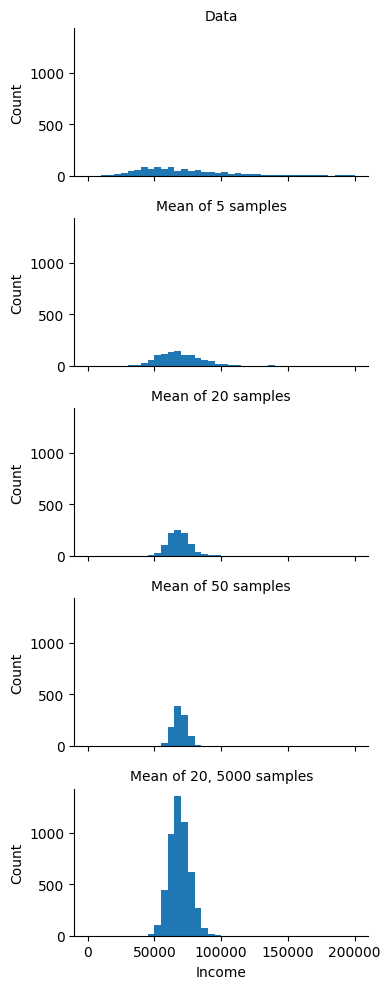

In [8]:
# plot resulting statistic distributions
g = sns.FacetGrid(results, col="type", col_wrap=1, height=2, aspect=2)
g.map(plt.hist, "income", range=[0, 200000], bins=40)
g.set_axis_labels("Income", "Count")
g.set_titles("{col_name}")

plt.tight_layout();

## Bootstrap

A bootstrap can be computed using scikit-learn's resample method (sampling with replacement).

In [9]:
def bootstrap(data, function, no_draws):
    results = []
    for draw in range(no_draws):
        sample = resample(data, replace=True)
        results.append(function(sample))

    # convert to pandas Series for easier statistic computation
    return pd.Series(results)

<Axes: ylabel='Frequency'>

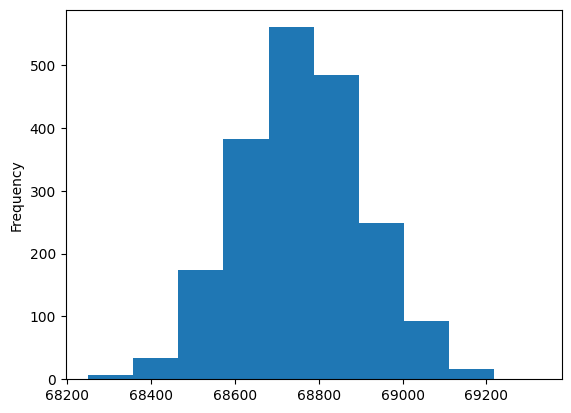

In [10]:
# also: we can use this example to showcase the central limit theorem (again),
# by changing the number of draws
mean_distribution = bootstrap(loans_income, np.mean, 2000)
mean_distribution.plot.hist()

In [11]:
print("Bootstrap Statistics:")
print(f"original data: {loans_income.mean()}")
# we compute standard error of means via standard deviation
# but: do not confuse the two
print(f"std. error: {mean_distribution.std()}")

Bootstrap Statistics:
original data: 68760.51844
std. error: 149.6198172612413


## Confidence Interval

In [12]:
print(loans_income.mean())
# create a sample of 20 loan income data
mean_distribution = bootstrap(loans_income, np.mean, 200)
mean_distribution
mean_distribution.quantile([0.05, 0.95])
confidence_interval = list(mean_distribution.quantile([0.05, 0.95]))

68760.51844


0      68754.27060
1      68606.92756
2      68565.87706
3      68789.22828
4      68627.19924
          ...     
195    68713.96870
196    68685.26402
197    68731.78602
198    68809.37220
199    68612.82056
Length: 200, dtype: float64

0.05    68522.672981
0.95    68998.595212
dtype: float64

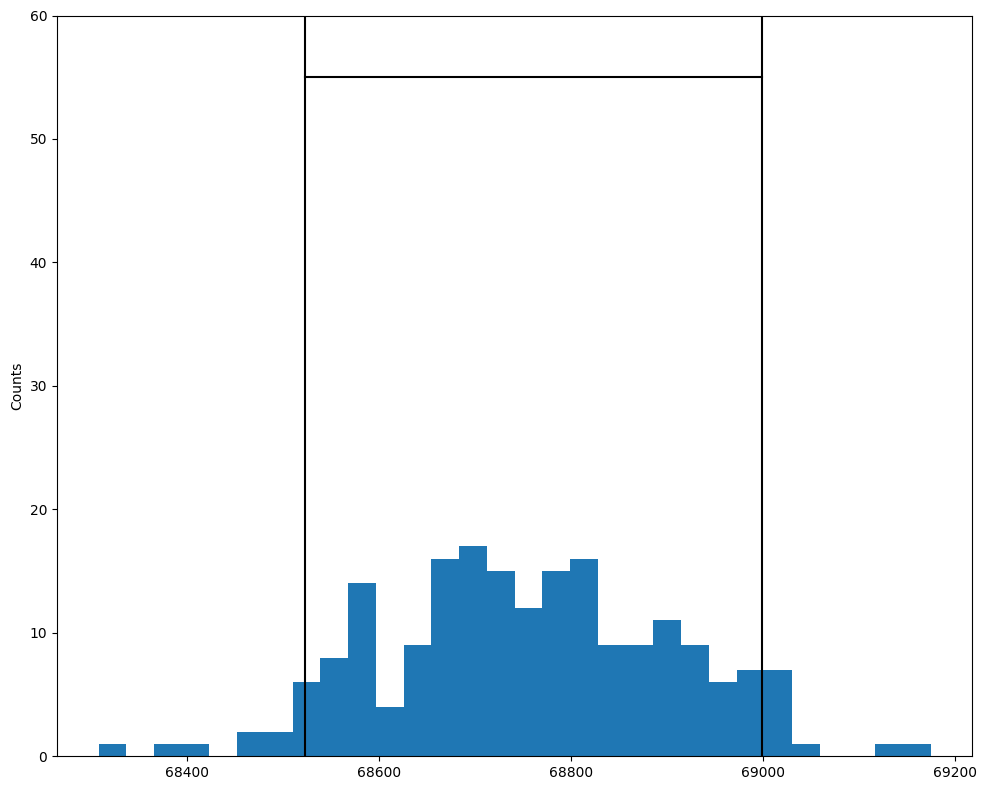

In [13]:
ax = mean_distribution.plot.hist(bins=30, figsize=(10, 8))
ax.plot(confidence_interval, [55, 55], color="black")
for x in confidence_interval:
    ax.plot([x, x], [0, 65], color="black")

ax.set_ylim(0, 60)
ax.set_ylabel("Counts")

plt.tight_layout();

## Hypothesis Tests

### First Examples

In [14]:
# read housing data
fieldnames = [
    "CRIM",
    "ZN",
    "INDUS",
    "CHAS",
    "NOX",
    "RM",
    "AGE",
    "DIS",
    "RAD",
    "TAX",
    "PTRATIO",
    "B",
    "LSTAT",
    "MEDV",
]
housing = pd.read_csv(
    os.path.join(data_dir, "housing.csv"), sep="\s+", names=fieldnames
)

In [15]:
# get first impression on data
housing

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0


In [16]:
# number of samples
housing.info

<bound method DataFrame.info of         CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   

     PTRATIO       B  LSTAT  MEDV  
0       15.3  396.90   4.98  24

In [17]:
r, p_value = pearsonr(housing["LSTAT"].values, housing["MEDV"].values)
print(f"Pearsons correlation coefficient: {r:.2f}, p-value: {p_value}")

Pearsons correlation coefficient: -0.74, p-value: 5.081103394387554e-88


The following code shows the Pearson correlation and t-test examples from the lecture slides.

In [18]:
points_homework = [5, 4, 7, 11, 21, 4, 6, 18, 12, 10, 15, 16]
points_test = [1, 8, 10, 13, 20, 5, 8, 17, 14, 8, 17, 11]
pearson_r, p_value = pearsonr(points_homework, points_test)

print(
    f"Pearsons correlation coefficient: {pearson_r:.2f} (p-value: {p_value:.2f})"
)

Pearsons correlation coefficient: 0.87 (p-value: 0.00)


In [19]:
# t-test example
group1 = [19, 19, 14, 23, 15, 18]
group2 = [13, 13, 8, 17, 9, 12]
t_statistic, p_value = ttest_ind(group1, group2, equal_var=True)
print(f"t-Test (independent): {t_statistic:.2f}, p-value: {p_value:.2f}")

t-Test (independent): 3.22, p-value: 0.01


### Cochran's Q and McNemar's Test

The following code example is adapted from (PyML), we have already used this example when discussing experimental setups.

In [20]:
# use non-html scikit output for better overview of outputs
set_config(display="text")

In [21]:
X, y = mnist_data()
X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Initializing Classifiers
clf1 = KNeighborsClassifier(algorithm="ball_tree", leaf_size=50)
clf2 = DecisionTreeClassifier(random_state=1)
clf3 = RandomForestClassifier(random_state=1)

# Building the pipelines
pipe1 = Pipeline([("std", StandardScaler()), ("clf1", clf1)])


# Setting up the parameter grids
param_grid1 = [{"clf1__n_neighbors": list(range(1, 10)), "clf1__p": [1, 2]}]

param_grid2 = [
    {
        "max_depth": list(range(1, 10)) + [None],
        "criterion": ["gini", "entropy"],
    }
]

param_grid3 = [{"n_estimators": [10, 100, 500, 1000]}]

In [22]:
# Setting up multiple GridSearchCV objects, 1 for each algorithm
gridcvs = {}
inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

for pgrid, est, name in zip(
    (param_grid1, param_grid2, param_grid3),
    (pipe1, clf2, clf3),
    ("KNN", "DTree", "RForest"),
):
    gcv = GridSearchCV(
        estimator=est,
        param_grid=pgrid,
        scoring="accuracy",
        n_jobs=-1,
        cv=inner_cv,
        verbose=0,
        refit=True,
    )
    gridcvs[name] = gcv

Next, we define the outer loop:
- The training folds from the outer loop will be used in the inner loop for model tuning
- The inner loop selects the best hyperparameter setting
- This best hyperparameter setting can be evaluated on both the avg. over the inner test folds and the 1 corresponding test fold of the outer loop

In [23]:
for name, gs_est in sorted(gridcvs.items()):

    print(50 * "-", "\n")
    print("Algorithm:", name)
    print("Inner loop:")

    outer_scores = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, valid_idx in outer_cv.split(X_train, y_train):
        # run inner loop hyperparam tuning
        gridcvs[name].fit(X_train[train_idx], y_train[train_idx])
        print(
            f"\nBest ACC (avg. of inner test folds): {gridcvs[name].best_score_ * 100:.2f}"
        )
        print(f"Best parameters: {gridcvs[name].best_params_}")

        # perf on test fold (valid_idx)
        outer_scores.append(
            gridcvs[name].best_estimator_.score(
                X_train[valid_idx], y_train[valid_idx]
            )
        )
        print(f"ACC (on outer test fold): {(outer_scores[-1]*100):.2f}")

    print("\n Outer Loop:")
    print(
        f"ACC {np.mean(outer_scores) * 100:.2f} (+/-{np.std(outer_scores) * 100:.2f})"
    )

-------------------------------------------------- 

Algorithm: DTree
Inner loop:


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 72.59
Best parameters: {'criterion': 'gini', 'max_depth': None}
ACC (on outer test fold): 75.50


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 74.03
Best parameters: {'criterion': 'entropy', 'max_depth': 7}
ACC (on outer test fold): 78.25


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 73.88
Best parameters: {'criterion': 'entropy', 'max_depth': 9}
ACC (on outer test fold): 77.38


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 73.38
Best parameters: {'criterion': 'entropy', 'max_depth': 8}
ACC (on outer test fold): 74.88


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, None]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 73.91
Best parameters: {'criterion': 'entropy', 'max_depth': 8}
ACC (on outer test fold): 77.75

 Outer Loop:
ACC 76.75 (+/-1.32)
-------------------------------------------------- 

Algorithm: KNN
Inner loop:


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('clf1',
                                        KNeighborsClassifier(algorithm='ball_tree',
                                                             leaf_size=50))]),
             n_jobs=-1,
             param_grid=[{'clf1__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'clf1__p': [1, 2]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 88.38
Best parameters: {'clf1__n_neighbors': 1, 'clf1__p': 1}
ACC (on outer test fold): 91.62


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('clf1',
                                        KNeighborsClassifier(algorithm='ball_tree',
                                                             leaf_size=50))]),
             n_jobs=-1,
             param_grid=[{'clf1__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'clf1__p': [1, 2]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 88.75
Best parameters: {'clf1__n_neighbors': 1, 'clf1__p': 1}
ACC (on outer test fold): 91.88


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('clf1',
                                        KNeighborsClassifier(algorithm='ball_tree',
                                                             leaf_size=50))]),
             n_jobs=-1,
             param_grid=[{'clf1__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'clf1__p': [1, 2]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 89.84
Best parameters: {'clf1__n_neighbors': 1, 'clf1__p': 1}
ACC (on outer test fold): 90.88


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('clf1',
                                        KNeighborsClassifier(algorithm='ball_tree',
                                                             leaf_size=50))]),
             n_jobs=-1,
             param_grid=[{'clf1__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'clf1__p': [1, 2]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 89.50
Best parameters: {'clf1__n_neighbors': 1, 'clf1__p': 1}
ACC (on outer test fold): 90.88


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('clf1',
                                        KNeighborsClassifier(algorithm='ball_tree',
                                                             leaf_size=50))]),
             n_jobs=-1,
             param_grid=[{'clf1__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'clf1__p': [1, 2]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 89.06
Best parameters: {'clf1__n_neighbors': 1, 'clf1__p': 1}
ACC (on outer test fold): 90.25

 Outer Loop:
ACC 91.10 (+/-0.58)
-------------------------------------------------- 

Algorithm: RForest
Inner loop:


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'n_estimators': [10, 100, 500, 1000]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 92.59
Best parameters: {'n_estimators': 1000}
ACC (on outer test fold): 95.00


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'n_estimators': [10, 100, 500, 1000]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 92.56
Best parameters: {'n_estimators': 500}
ACC (on outer test fold): 94.50


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'n_estimators': [10, 100, 500, 1000]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 92.78
Best parameters: {'n_estimators': 1000}
ACC (on outer test fold): 94.25


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'n_estimators': [10, 100, 500, 1000]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 92.88
Best parameters: {'n_estimators': 500}
ACC (on outer test fold): 92.62


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=1, shuffle=True),
             estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid=[{'n_estimators': [10, 100, 500, 1000]}],
             scoring='accuracy')


Best ACC (avg. of inner test folds): 92.75
Best parameters: {'n_estimators': 500}
ACC (on outer test fold): 93.12

 Outer Loop:
ACC 93.90 (+/-0.89)


In [24]:
# Cochran's Q
q_statistic, p_value = cochrans_q(
    y_test,
    gridcvs["DTree"].best_estimator_.predict(X_test),
    gridcvs["KNN"].best_estimator_.predict(X_test),
    gridcvs["RForest"].best_estimator_.predict(X_test),
)

print(f"Cochran's Q: {q_statistic:.2f}, p-value: {p_value:.2f}")

Cochran's Q: 191.71, p-value: 0.00


This shows us that there is a significant difference between the performances --> now do pairwise tests for further investigation using McNemar's test.

In [25]:
# hypothesis testing
# pair-wise via mcnemar
tb = mcnemar_table(
    y_target=y_test,
    y_model1=gridcvs["RForest"].best_estimator_.predict(X_test),
    y_model2=gridcvs["KNN"].best_estimator_.predict(X_test),
)
# print(tb)
chi2, p = mcnemar(ary=tb, corrected=True)
print(f"[RForest vs. KNN]: chi-squared: {chi2:.2f}, p-value: {p:.2f}")


tb = mcnemar_table(
    y_target=y_test,
    y_model1=gridcvs["DTree"].best_estimator_.predict(X_test),
    y_model2=gridcvs["KNN"].best_estimator_.predict(X_test),
)

# print(tb)
chi2, p = mcnemar(ary=tb, corrected=True)
print(f"[DTree vs. KNN]: chi-squared: {chi2:.2f}, p-value: {p:.2f}")

tb = mcnemar_table(
    y_target=y_test,
    y_model1=gridcvs["DTree"].best_estimator_.predict(X_test),
    y_model2=gridcvs["RForest"].best_estimator_.predict(X_test),
)

# print(tb)
chi2, p = mcnemar(ary=tb, corrected=True)
print(f"[DTree vs. KNN]: chi-squared: {chi2:.2f}, p-value: {p:.2f}")

[RForest vs. KNN]: chi-squared: 5.13, p-value: 0.02
[DTree vs. KNN]: chi-squared: 89.55, p-value: 0.00
[DTree vs. KNN]: chi-squared: 141.32, p-value: 0.00


### 5x2CV Paired t-Test

Alternatively, we can also perform a paired t-test.

In [26]:
t_statistic, p_value = paired_ttest_5x2cv(
    estimator1=gridcvs["RForest"].best_estimator_,
    estimator2=gridcvs["KNN"].best_estimator_,
    X=X,
    y=y,
    random_seed=1,
)

print(f"t-statistic: {t_statistic:.3f}, p-value: {p_value:.3f}")

t-statistic: 5.185, p-value: 0.004
